In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn.functional as F
from keras.datasets import mnist
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X.reshape(-1, 28 * 28)
test_X = test_X.reshape(-1, 28 * 28)

train_X = (torch.from_numpy(train_X).float().reshape(-1, 28 * 28) / 255).to(device)
train_y = torch.from_numpy(train_y).long().to(device)

test_X = (torch.from_numpy(test_X).float().reshape(-1, 28 * 28) / 255).to(device)
test_y = torch.from_numpy(test_y).long().to(device)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
class MLP(nn.Module):
    def __init__(self, act=nn.ReLU()):
        super().__init__()
        self.act = act
        self.l1 = nn.Linear(28 * 28, 128)
        self.l2 = nn.Linear(128, 128)
        self.l3 = nn.Linear(128, 64)
        self.l4 = nn.Linear(64, 10)
        # we ignore the solfmax layer here, because we will be predicting the logits
        
    def forward(self, x):
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        x = self.act(x)
        x = self.l3(x)
        x = self.act(x)
        x = self.l4(x)
        return x
    
    def predict(self, x):
        return self.forward(x).argmax(dim=1)

In [4]:
def train(model, lr=0.01, epochs=100, verbose=False, optimizer='adam', reg=0):
	loss = nn.CrossEntropyLoss()
	optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=reg) if optimizer == 'adam' else torch.optim.SGD(model.parameters(), lr=lr).to(device)
	
	losses = []
	for i in range(epochs):
		optim.zero_grad()
		pred = model(train_X)
		l = loss(pred, train_y)
		l.backward()
		optim.step()
		losses.append(l.item())
  
		if verbose and i % (epochs//10) == 0:
			print(f"Epoch {i} Loss: {l.item()}")
  
	return losses

In [5]:
model = MLP(act=nn.Sigmoid()).to(device)
losses = train(model, lr=0.001, epochs=5000, verbose=True, reg=1e-5)

Epoch 0 Loss: 2.32873272895813
Epoch 500 Loss: 0.097419373691082
Epoch 1000 Loss: 0.012913870625197887
Epoch 1500 Loss: 0.005220979452133179
Epoch 2000 Loss: 0.0035765517968684435
Epoch 2500 Loss: 0.002834911923855543
Epoch 3000 Loss: 0.002161999698728323
Epoch 3500 Loss: 0.001841495162807405
Epoch 4000 Loss: 0.0016334813553839922
Epoch 4500 Loss: 0.001490329741500318


In [6]:
def print_metrics(model):
    with torch.no_grad():
        pred = model.predict(test_X)
        acc = (pred == test_y).float().mean()
        print(f"Accuracy: {acc.item()}")

        cm = confusion_matrix(test_y.cpu().numpy(), pred.cpu().numpy())
        f1 = f1_score(test_y.cpu().numpy(), pred.cpu().numpy(), average=None)
            
        accuracies = []
        recalls = []

        for i in range(10):
            accuracies.append(cm[i, i] / (cm[:, i].sum() + 1e-7))
            recalls.append(cm[i, i] / (cm[i].sum() + 1e-7))
        df = pd.DataFrame(np.array([f1, accuracies, recalls]).T, index=range(10), columns=["F1 Score", "Accuracy", "Recall"])
        df.index.name = "Class"
        display(df.T)

        plt.figure(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

def plot_losses(losses):
    plt.plot(losses)
    plt.title("Losses")
    plt.xlabel("Epoch")
    plt.ylabel("Loss") 

Accuracy: 0.9732999801635742


Class,0,1,2,3,4,5,6,7,8,9
F1 Score,0.984741,0.988576,0.974284,0.967838,0.977053,0.964286,0.977011,0.968370,0.965092,0.963111
Accuracy,0.981744,0.985977,0.975705,0.967359,0.978550,0.960000,0.978033,0.968841,0.965092,0.968907
Recall,0.987755,0.991189,0.972868,0.968317,0.975560,0.968610,0.975992,0.967899,0.965092,0.957384


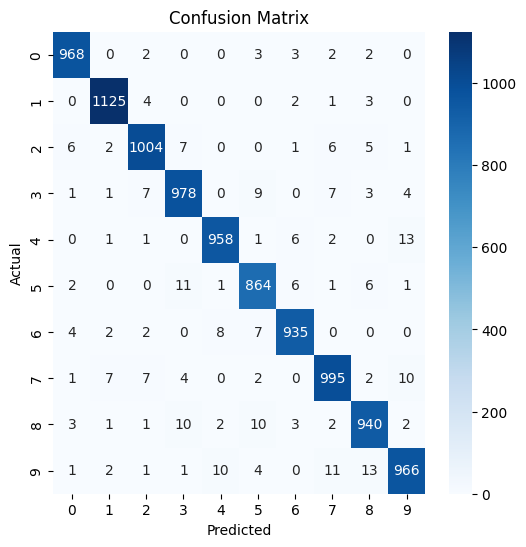

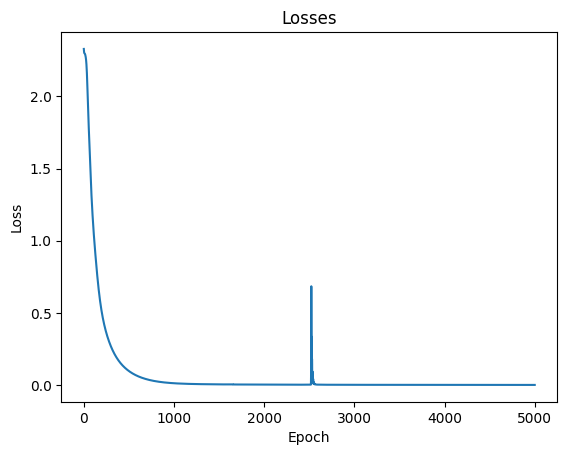

In [7]:
print_metrics(model)
plot_losses(losses)

torch.save(model, 'mlp_large.pth')

In [8]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear = nn.Linear(28 * 28, 10)
        # Note that the activation is automatically applied in the loss function.
        
    def forward(self, x):
        return self.linear(x)
    
    def predict(self, x):
        return self.forward(x).argmax(dim=1)

In [9]:
model = LogisticRegression().to(device)
losses = train(model, lr=3e-4, epochs=5000, verbose=True)

Epoch 0 Loss: 2.338815689086914
Epoch 500 Loss: 0.5376607179641724
Epoch 1000 Loss: 0.39382871985435486
Epoch 1500 Loss: 0.33996298909187317
Epoch 2000 Loss: 0.3106463849544525
Epoch 2500 Loss: 0.2916393280029297
Epoch 3000 Loss: 0.2780061960220337
Epoch 3500 Loss: 0.2675793766975403
Epoch 4000 Loss: 0.2592509686946869
Epoch 4500 Loss: 0.2523917555809021


Accuracy: 0.9267999529838562


Class,0,1,2,3,4,5,6,7,8,9
F1 Score,0.966700,0.973730,0.915020,0.909990,0.932995,0.891938,0.944703,0.924427,0.885845,0.912525
Accuracy,0.956088,0.967798,0.933468,0.909091,0.930162,0.910152,0.935517,0.926686,0.875627,0.915254
Recall,0.977551,0.979736,0.897287,0.910891,0.935845,0.874439,0.954071,0.922179,0.896304,0.909812


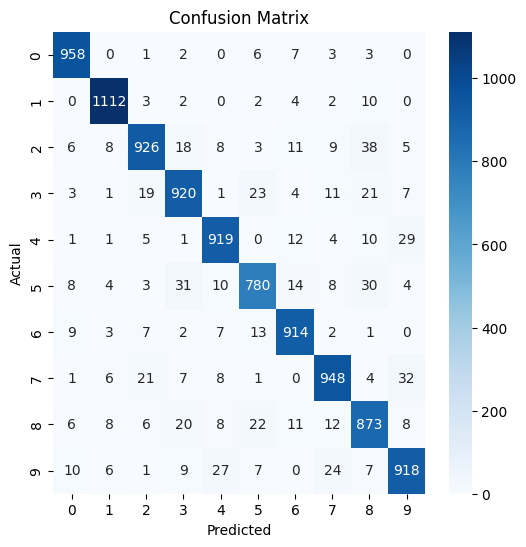

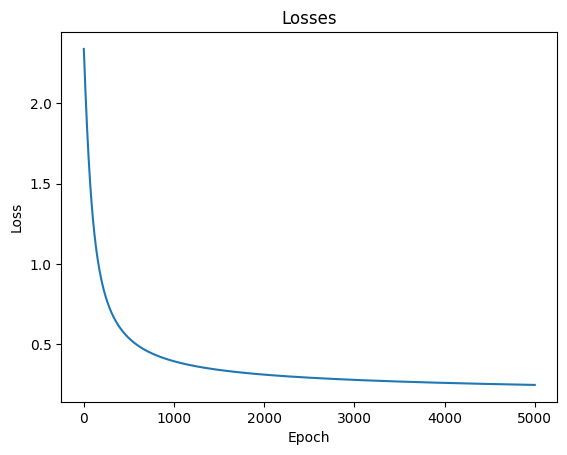

In [10]:
print_metrics(model)
plot_losses(losses)
torch.save(model, 'lr.pth')

In [13]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, criterion='gini')
rf.fit(train_X.cpu(), train_y.cpu())

# print_metrics(rf)

KeyboardInterrupt: 

In [11]:
class MLP(nn.Module):
	def __init__(self, act=nn.ReLU()):
		super().__init__()
		self.l1 = nn.Linear(28 * 28, 30)
		self.l2 = nn.Linear(30, 20)
		self.l3 = nn.Linear(20, 10)
		self.act = act
  
	def forward(self, x):
		x = self.l1(x)
		x = self.act(x)
		x = self.l2(x)
		x = self.act(x)
		x = self.l3(x)
		return x

	def predict(self, x):
		return self.forward(x).argmax(dim=1)

	def get_feats(self, x):
		feats = []
		x = self.l1(x)
		x = self.act(x)
		feats.append(x.detach().cpu().numpy())
		x = self.l2(x)
		x = self.act(x)
		feats.append(x.detach().cpu().numpy())
		x = self.l3(x)
		feats.append(x.detach().cpu().numpy())

		return feats

In [12]:
model = MLP(act=nn.Sigmoid()).to(device)
losses = train(model, lr=1e-3, epochs=2000, verbose=True)

Epoch 0 Loss: 2.3494770526885986
Epoch 200 Loss: 1.370924472808838
Epoch 400 Loss: 0.7223779559135437
Epoch 600 Loss: 0.4481320083141327
Epoch 800 Loss: 0.31671544909477234
Epoch 1000 Loss: 0.2428949922323227
Epoch 1200 Loss: 0.1954164057970047
Epoch 1400 Loss: 0.16228774189949036
Epoch 1600 Loss: 0.13738064467906952
Epoch 1800 Loss: 0.11800014972686768


Accuracy: 0.9529999494552612


Class,0,1,2,3,4,5,6,7,8,9
F1 Score,0.978788,0.983289,0.943853,0.937469,0.950870,0.927190,0.960540,0.95428,0.942387,0.944804
Accuracy,0.969000,0.981563,0.942940,0.932419,0.955761,0.941109,0.955579,0.95428,0.944330,0.948104
Recall,0.988776,0.985022,0.944767,0.942574,0.946029,0.913677,0.965553,0.95428,0.940452,0.941526


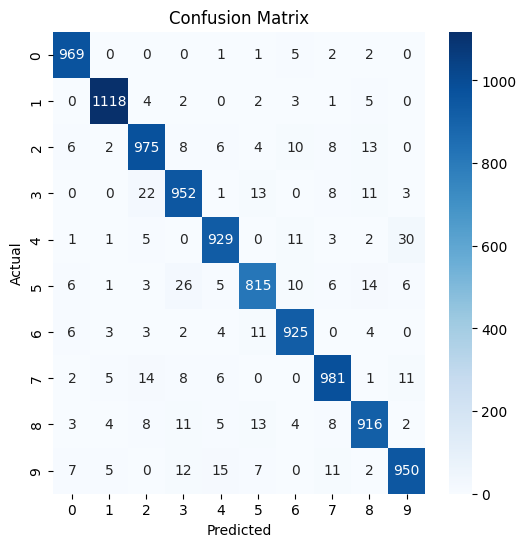

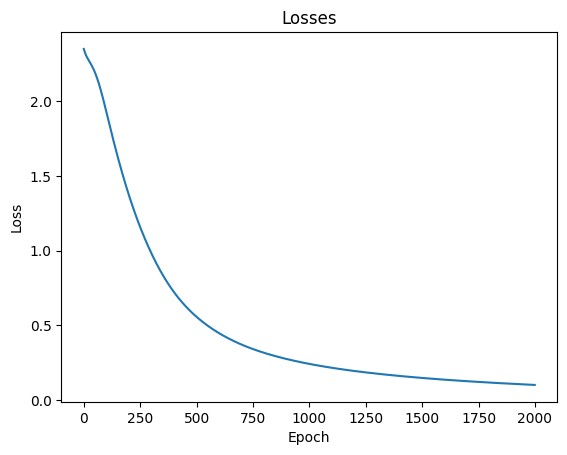

In [13]:
print_metrics(model)
plot_losses(losses)

torch.save(model, 'MLP.pth')

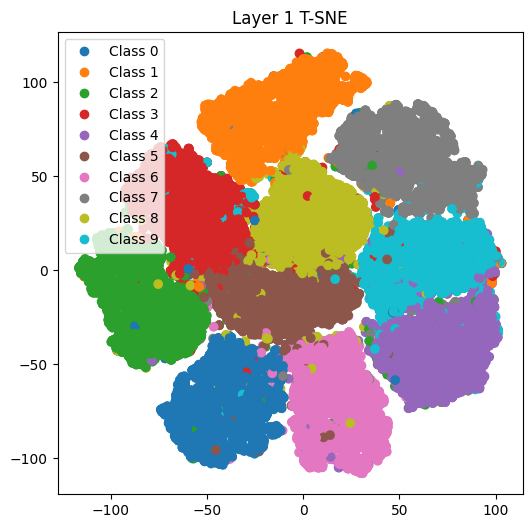

KeyboardInterrupt: 

In [11]:
from sklearn.manifold import TSNE

feats = model.get_feats(train_X)

for i in range(len(feats)):
	tsne = TSNE(n_components=2, random_state=42)
	embeddings_2d = tsne.fit_transform(feats[i])
	plt.figure(figsize=(6, 6))
	scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=train_y.detach().cpu().numpy(), cmap="tab10")
	# print the legend of the classes
	legend_labels = [f"Class {label}" for label in range(10)]
	plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels)
	plt.title(f"Layer {i + 1} T-SNE")
	plt.show()